Processing CHIME FRB180916.J0158+65
=====

see CHIME et al. 2020b "Periodic activity from a fast radio burst source"    
This notebook processes the bursts using the data released by CHIME and dedisperses the data further to study how the DM affects the final trend

  0%|          | 0/25 [00:00<?, ?it/s]

Processing with delta dm: 0


C:\Users\hmsmo\AppData\Roaming\Python\Python37\site-packages\skimage\measure\block.py:87: RuntimeWarning: Mean of empty slice
  **func_kwargs)
B:\dev\sadtrombone\universal\corrfns.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[0:nx,:] = result_shifted[nx-1:2*nx-1,:]
B:\dev\sadtrombone\universal\corrfns.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[nx:2*nx-1,:] = result_shifted[0:nx-1,:]
100%|██████████| 25/25 [00:01<00:00, 16.74it/s]


,amplitude,xo,yo,sigmax,sigmay,theta,drift (mhz/ms),angle
13.0,200.000000,80.407968,64.005301,14.931826,1.688729,1.789540,-28.600117,1.789540
14.0,652.605148,80.362354,64.339470,2.630949,8.604297,0.609741,-9.101675,-0.961055
15.0,95.938058,140.409694,64.352958,12.106750,5.645504,2.062480,-11.871520,2.062480
15.5,527.529669,176.365099,64.243880,3.039805,8.197538,0.506631,-11.456694,-1.064165
16.0,471.367870,80.277935,64.090880,2.125115,4.835542,0.287827,-21.475653,-1.282969
18.0,2712.600356,80.460995,64.335280,14.449545,3.211479,1.942930,-16.288749,1.942930
19.0,1259.746447,80.379281,64.297830,8.573349,-2.708255,2.169715,-9.314804,2.169715
21.0,315.111128,80.294710,64.265043,8.833778,3.815343,-0.987329,-9.631106,-0.987329
23.0,4302.701500,80.481257,64.129712,13.979072,2.061264,1.814525,-25.567108,1.814525
24.0,185.413128,80.163942,64.042482,2.684536,5.228036,3.522662,-15.868674,1.951865


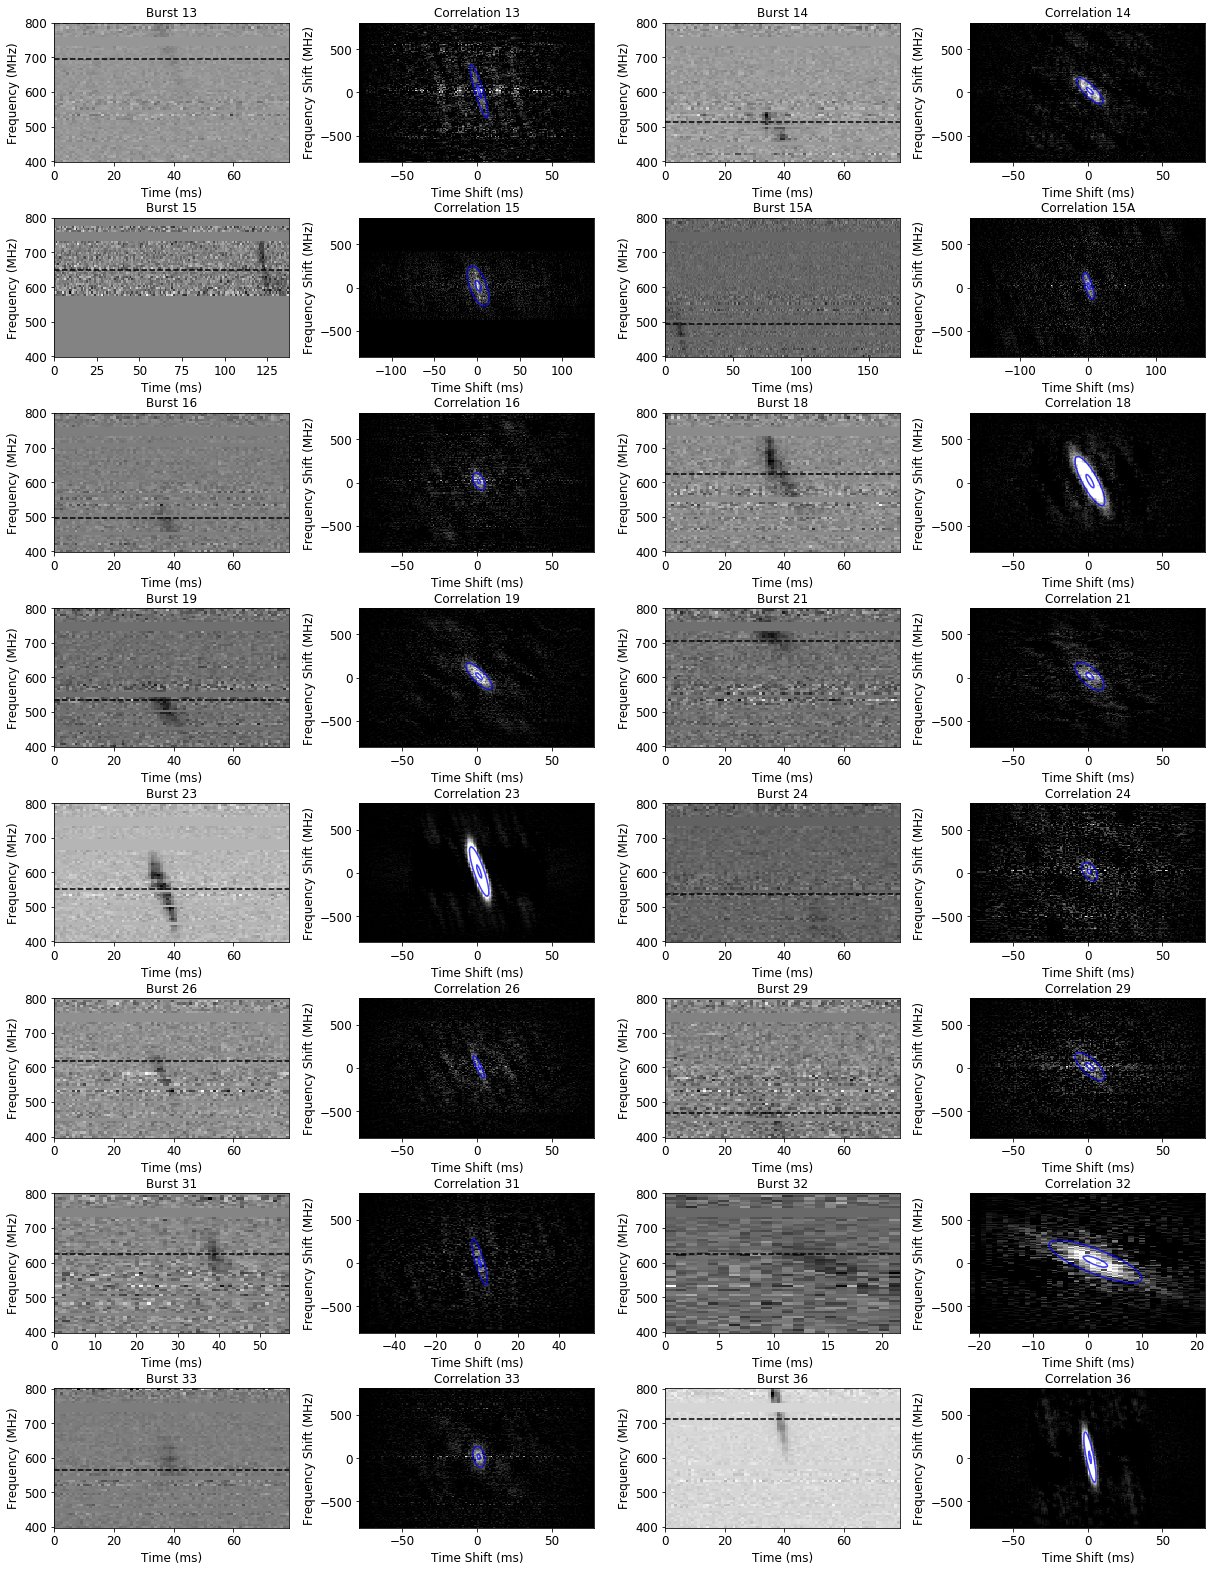

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import os
from tqdm import tqdm
import skimage.measure
import corrfns, fitburst
import itertools

folder = 'data/CHIME_180916.J0158+65'
burstfiles = [s for s in os.listdir(folder) if '16k' in s]

ddm = 0
centerDM180916 = 348.82 # pc/cm3
print("Processing with delta dm:", ddm)
parameterfile = '{}/chime_180916_fit_params_ddm{}.csv'.format(folder, ddm)
errorfile     = '{}/chime_180916_param_errors_ddm{}.csv'.format(folder, ddm)

cmap = plt.get_cmap('gray_r')
cmap.set_bad(color = 'w', alpha = 1.)

if os.path.exists(parameterfile):
    popts = pd.read_csv(parameterfile, index_col=0)
    perrs = pd.read_csv(errorfile, index_col=0)
else:
    popts, perrs = [], []

drifts       = []
drift_errors = []
red_chisqs   = []
angles       = [] # standardize theta to be in [0, pi] 
keys         = []
center_fs    = []

def findCenter(burstwindow):
    #freqspectrum = np.nanmean(burstwindow, axis=1)
    # To be honest I wrote this with pandas a long time ago and I'm not sure why but it works
    freqspectrum = pd.DataFrame(burstwindow.sum(axis=1)[:, None])
    data = freqspectrum[:][0]
    x = data.keys()
    xo = np.nansum(x*data)/np.nansum(data)
    #xo = np.nansum(x*data)/np.nansum(x)
    return xo # return the central frequency 

def findCenterBetter(burstwindow):
    freqspectrum = burstwindow.sum(axis=1)[:, None]
    freqi = np.indices(freqspectrum.shape)[0]
    return np.nansum(freqi*freqspectrum) / np.nansum(freqspectrum)

def dedisperse(intensity, DM, nu_low, chan_width, timestep, cshift=0):
    dedispersed = np.copy(intensity)

    shifts = [0 for i in range(0, len(intensity))]
    high_ref_freq = nu_low + len(dedispersed)*chan_width
    low_ref_freq  = nu_low
    
    for i, row in enumerate(dedispersed): # i == 0 corresponds to 400Mhz
        nu_i = nu_low + i*chan_width
        # High frequency anchor
        deltat = -4.14937759336e6 * (nu_i**-2 - high_ref_freq**-2) * DM

        # Low frequency anchor
        #deltat = 4.14937759336e6 * (low_ref_freq**-2 - nu_i**-2) * DM

        channelshift = int(round(deltat/timestep))
        dedispersed[i] = np.roll(dedispersed[i], channelshift)

    # center view automatically, doesn't really work
    #ts = np.nanmean(dedispersed, axis=1)
    #peak_idx = np.nanargmax(ts)
    #plt.plot(range(0, len(ts)), ts)
    #cshift = int(dedispersed.shape[1]/2 - peak_idx)

    # optionally center view
    dedispersed = np.roll(dedispersed, cshift, axis=1)
   
    return dedispersed

def processBurst(burstwindow, burstkey, p0=[], popt_custom=[], bounds=(-np.inf, np.inf), nclip=None, clip=None, ploti=None):
    """
    Given a waterfall of a burst, will use the 2d autocorrelation+gaussian fitting method to find the drift and make a plot of the burst and fit.
    Parameters are added to the global lists above before being saved in a table. Eventually I may want to make this more standalone
    """
    corr = corrfns.auto_corr2D_viafft(burstwindow)
    if nclip != None or clip != None:
        corr = np.clip(corr, nclip, clip)
    #print(burstwindow.shape, corr.shape)
    #### Autocorr noise
    autocorr_sigma = np.std( corr[:, 0:100] )
    # print('autocorr_sigma', autocorr_sigma)
    # auto_sigmas.append(autocorr_sigma)

    #### Fit Gaussian to autocorrelation. Load from parameter file if already found.
    if os.path.exists(parameterfile) and popt_custom == []:
        # print('loading fit...')
        popt, perr = popts.loc[burstkey][:6], perrs.loc[burstkey][:6]
    elif popt_custom != []:
        popt, perr = popt_custom, [-1, -1, -1, -1, -1, -1]
    else:        
        print("finding fit {}...".format(burstkey))
        try:
            popt, pcov = fitburst.fitgaussiannlsq(corr, p0=p0, sigma=autocorr_sigma, bounds=bounds)
            perr = np.sqrt(np.diag(pcov))
            print('solution nlsq:', popt)
            print('parameter 1sigma:', perr)
            #print('pcov diag:', np.diag(pcov))
        except (RuntimeError, ValueError, IndexError):
            print('no fit found')
            popt, perr = [-1,-1,-1,-1,-1,-1], [-1,-1,-1,-1,-1,-1]
            if popt_custom != []:
                popt = popt_custom
    popts.append(popt)
    perrs.append(perr)

    x, y = np.meshgrid(range(0, corr.shape[1]), range(0, corr.shape[0]))
    #popt[5] = 0.1
    fitmap = fitburst.twoD_Gaussian((y, x), *popt).reshape(corr.shape[0], corr.shape[1])
    
    # calculate reduced chisquared
    residuals = corr - fitmap
    chisq = np.sum((residuals / autocorr_sigma) ** 2)
    red_chisq = chisq / (corr.shape[0]*corr.shape[1] - len(popt)) # this is chisq/(M-N)
    red_chisqs.append(red_chisq)
    # print('reduced chisq:', red_chisq)
    
    # Calculate drifit
    theta = popt[5] if abs(popt[3]) > abs(popt[4]) else popt[5] - np.pi/2
    angles.append(theta) #if theta > 0 else angles.append(theta + 2*np.pi)
    slope = np.tan(theta) 
    conversion = freq_res / (time_res)
    drift = conversion * slope # MHz/ms
    theta_err = perr[-1] # do i need to correct this for pixel scale?
    drift_error = conversion * (theta_err * (1/np.cos(theta))**2) 
    
    drifts.append(drift)
    drift_errors.append(drift_error)
    
    # find center frequency. mask noisy channels where necessary
    #center_f = findCenter(burstwindow)*freq_res + lowest_freq
    if burstkey == 29:
        center_f = findCenterBetter(burstwindow[0:30])*freq_res + lowest_freq
    else:
        center_f = findCenterBetter(burstwindow)*freq_res + lowest_freq
    center_fs.append(center_f)
    
    #### Plot
    extents = (0, 
               time_res*burstwindow.shape[1],
               lowest_freq - freq_res/2., 
               lowest_freq + freq_res*burstwindow.shape[0])
    
    corrextents = (-extents[1], extents[1], -(extents[3]-extents[2])*2, (extents[3]-extents[2])*2)
    
    nrows = 8
    burstkey = '15A' if burstkey == 15.5 else burstkey
    if ploti == None:
        plt.figure(figsize=(15, 5))
        plt.subplot(121)
    else:
        plt.subplot(nrows, 4, next(ploti))

    plt.title("Burst {}".format(burstkey), fontsize=fontsize)
    #plt.title("Burst {} at $\Delta$DM$={}$ pc/cm$^{{-3}}$".format(burstkey, ddm), fontsize=fontsize)
    
    
    plt.imshow(burstwindow, aspect='auto', cmap=cmap, extent=extents, origin='lower') # white is 0, black is 1
    plt.axhline(y=center_f, ls='--', c='k')
    plt.xlabel("Time (ms)")
    plt.ylabel("Frequency (MHz)")
    #plt.colorbar()

    if ploti == None:
        plt.subplot(122)
    else:
        plt.subplot(nrows, 4, next(ploti))
    plt.title("Correlation {}".format(burstkey), fontsize=fontsize)
    #plt.title("Correlation {} at $\Delta$DM$={}$ pc/cm$^{{-3}}$".format(burstkey, ddm), fontsize=fontsize)
    plt.imshow(corr, aspect='auto', cmap='gray', extent=corrextents, origin='lower')
    plt.clim(0, np.max(corr)/10)
    plt.xlabel("Time Shift (ms)")
    plt.ylabel("Frequency Shift (MHz)")
    #plt.colorbar()
    if popt[0] > 0:
        plt.contour(fitmap, [popt[0]/4, popt[0]*0.9], colors='b', alpha=0.75, extent=corrextents, origin='lower')
        
    return drift, drift_error

wellfit      = [14, 18, 19, 21, 23, 26, 33, 36]
multiburst   = [15, 24, 31]
exclude      = [12, 17, 20, 22, 27, 28, 30, 34, 35, 37, 38] # too weak, cutoff, or strange morphologies
singleburst  = 29

time_res = 0.98304 # ms
freq_res = 6.25 # MHz
lowest_freq = 400.20751953125 # MHZ


plt.figure(figsize=(8.5*2, 11*2))
#plt.suptitle("180916.J0158+65 Data from CHIME/FRB 2020 et al. ", size=20, y=1.01)
ploti = itertools.count(start=1, step=1)
# ploti = itertools.count(start=5, step=1)

fontsize = 12
plt.rcParams.update({'font.size': fontsize})

for filename in tqdm(burstfiles):
    burstnum = int(filename.split('burst_')[1][:2])
    if burstnum in exclude:
        continue
#     if burstnum not in [23, 36]:
#         continue
#     if burstnum != singleburst:
#         continue

    data = np.load("{}/{}".format(folder, filename))
    
    wfall = data["wfall"]
    downsample = 256
    wfall_down = skimage.measure.block_reduce(wfall, block_size=(downsample, 1), func=np.nanmean)
    # print(wfall_down.shape, wfall.shape)
    
    dt_s = data["dt_s"]
    center_freq_mhz = data["center_freq_mhz"]
    df_mhz = center_freq_mhz[1] - center_freq_mhz[0]
    # print(dt_s, center_freq_mhz[0], center_freq_mhz[-1], df_mhz)
    
    burstwindow = wfall_down - wfall_down[:, 0:20].mean(axis=1)[:,None]
    burstwindow = np.nan_to_num(wfall_down)
    #burstwindow = dedisperse(burstwindow, ddm, lowest_freq, freq_res, time_res)

    ### PROCESS
    # set up initial guesses for problem bursts
    cshift = 0
    if burstnum == 13:
        if ddm == 0.5:
            p0 = [200, 80.2949248000688, 64.3282045543879, 12.8135786074679, 1.75982726655571, 1.56923145023643]
            bounds = (0, (200, *(np.inf,)*5))
            clip = 3000
        else:
            p0 = [73.331241, 80.394175, 64.434706, 28.821658, 2, 2.352088]
            bounds = (0, (200, *(np.inf,)*5))
            clip = 3000
    elif burstnum == 14:
        p0 = [200, 80.2949248000688, 64.3282045543879, 12.8135786074679, 1.75982726655571, 1.56923145023643]
        bounds = (0, np.inf)
        clip = None
    elif burstnum == 15:
        p0 = [186.940307, 140.371332, 64.427185, 20, 2, 2.36414]
        bounds = (0, np.inf)
        clip = 5500
    elif burstnum == 16:
        p0 = []
        bounds = (0, np.inf)
        clip = 4000
    elif burstnum == 24:
        if ddm == -2 or ddm == -1:
            p0 = [185.413128462878, 80.1639417218768, 64.0424815070787, 8, 2.68453635647628, 2.1]
            bounds = (0, np.inf)
            clip = 1000
            cshift = -30
        else:
            p0 = []
            bounds = (0, np.inf)
            clip = 2000
    elif burstnum == 26:
        if ddm == -2 or ddm == -1:
            p0 = [411.048974292209, 80.2175140873591, 63.9702485156176, 12, 1, 2.3]
            bounds = (0, np.inf)
            clip = 3000 if ddm == -1 else 2000
        elif ddm == 0.5:
            clip = 2000
        else:
            p0 = []
            bounds = (0, np.inf)
            clip = 3000
    elif burstnum == 29:
        p0 = [175, 80.338841, 64.32839, 13.560142, 2, 2.348835]
        bounds = (0, np.inf)
        clip = 2000
    elif burstnum == 31:
        p0 = [100, 59, 64.11432329, 10, 2, 1.7]
        if ddm == -2:
            cshift = -20, 5
        elif ddm == -1:
            cshift = -5, 11
        else:
            cshift = 0, 0
        bounds = (0, (200, *(np.inf,)*5))
        clip = None
    else:
        p0 = []
        bounds = (-np.inf, np.inf)
        clip = None
        
    # split multi bursts
    if burstnum in multiburst:
        if burstnum == 15:
            burstwindow = dedisperse(burstwindow, ddm, lowest_freq, freq_res, time_res)
            tsplit = 140
            if ddm == -2 or ddm == -1 or ddm == 0 or ddm == 0.5:
                windowtweaked = np.copy(burstwindow)
                windowtweaked[0:28] = 0
                windowtweaked[60:64] = 0
                processBurst(windowtweaked[:, :tsplit], burstnum, p0=p0, bounds=bounds, ploti=ploti)
            else:
                processBurst(burstwindow[:, :tsplit], burstnum, bounds=bounds, ploti=ploti)
            keys.append(burstnum)
            
            if ddm == -2 or ddm == -1:
                # remove striped remnants of burst 15
                stripes = (5, 20) if ddm == -2 else (0, 11)
                burstwindow[:, tsplit+4:][:, stripes[0]:stripes[1]] = 0
                processBurst(burstwindow[:, tsplit+4:], 15.5, bounds=bounds, clip=clip, ploti=ploti)
            else:
                processBurst(burstwindow[:, tsplit+4:], 15.5, bounds=bounds, clip=clip, ploti=ploti)
            keys.append(15.5)
        elif burstnum == 24:
            burstwindow = dedisperse(burstwindow, ddm, lowest_freq, freq_res, time_res, cshift=cshift)
            tsplit = 80
            
            if ddm == -2 or ddm == -1:
                processBurst(burstwindow[:, :tsplit], burstnum, p0=p0, bounds=bounds, clip=clip, ploti=ploti)
            else:
                processBurst(burstwindow[:, :tsplit], burstnum, bounds=bounds, clip=clip, ploti=ploti)
            keys.append(burstnum)
            
            #processBurst(burstwindow[:, tsplit:], burstnum+1, bounds=bounds, clip=clip, ploti=ploti)
            #keys.append(burstnum+1)
        elif burstnum == 31:
            #burstwindow = dedisperse(burstwindow, ddm, lowest_freq, freq_res, time_res)
            
            tsplit = 58
            left_burst = dedisperse(burstwindow[:, :tsplit], ddm, lowest_freq, freq_res, time_res, cshift=cshift[0])
            right_burst = dedisperse(burstwindow[:, tsplit:], ddm, lowest_freq, freq_res, time_res, cshift=cshift[1])
            
            processBurst(left_burst, burstnum, bounds=bounds, clip=clip, p0=p0, ploti=ploti)
            keys.append(burstnum)
            
            if ddm == 0.5:
                p0_32 = [155.251758447181, 22.4046763407628, 64.3851739155131, 12, 3, 2]
                processBurst(right_burst, burstnum+1, bounds=bounds, p0=p0_32, nclip=0, clip=1000, ploti=ploti)
            else:
                processBurst(right_burst, burstnum+1, ploti=ploti)
            keys.append(burstnum+1)
    else:
        burstwindow = dedisperse(burstwindow, ddm, lowest_freq, freq_res, time_res, cshift=cshift)
        processBurst(burstwindow, burstnum, p0=p0, bounds=bounds, clip=clip, ploti=ploti)
        keys.append(burstnum)
    
plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)
plt.savefig('bursts180916_ddm_{}.pdf'.format(ddm))
# plt.savefig('compare_ddm_{}.pdf'.format(ddm))

select_bursts = keys
if not os.path.exists(parameterfile):
    popts = pd.DataFrame(popts, index=keys, columns=['amplitude', 'xo', 'yo', 'sigmax', 'sigmay', 'theta'])
    perrs = pd.DataFrame(perrs, index=keys, columns=['amp_error', 'xo_error', 'yo_error', 'sigmax_error', 'sigmay_error', 'angle_error'])

    try:
        popts['drift (mhz/ms)']       = drifts
        popts['angle']                = angles
        popts['center_f']             = center_fs
        perrs['drift error (mhz/ms)'] = drift_errors
        perrs['red_chisq']            = red_chisqs

        popts.to_csv(parameterfile, index_label="name")
        perrs.to_csv(errorfile, index_label="name")
    except ValueError:
        print('not updating database')
    
    display(popts.loc[select_bursts])
else:
    newparams = pd.DataFrame(popts.loc[select_bursts], index=keys, columns=['amplitude', 'xo', 'yo', 'sigmax', 'sigmay', 'theta', 'drift (mhz/ms)', 'angle'])
    newparams['drift (mhz/ms)']       = drifts
    newparams['angle']                = angles
    display(newparams.loc[select_bursts])


### Baseband data

(64, 900)
(64, 900)
(64, 600)
(64, 900)


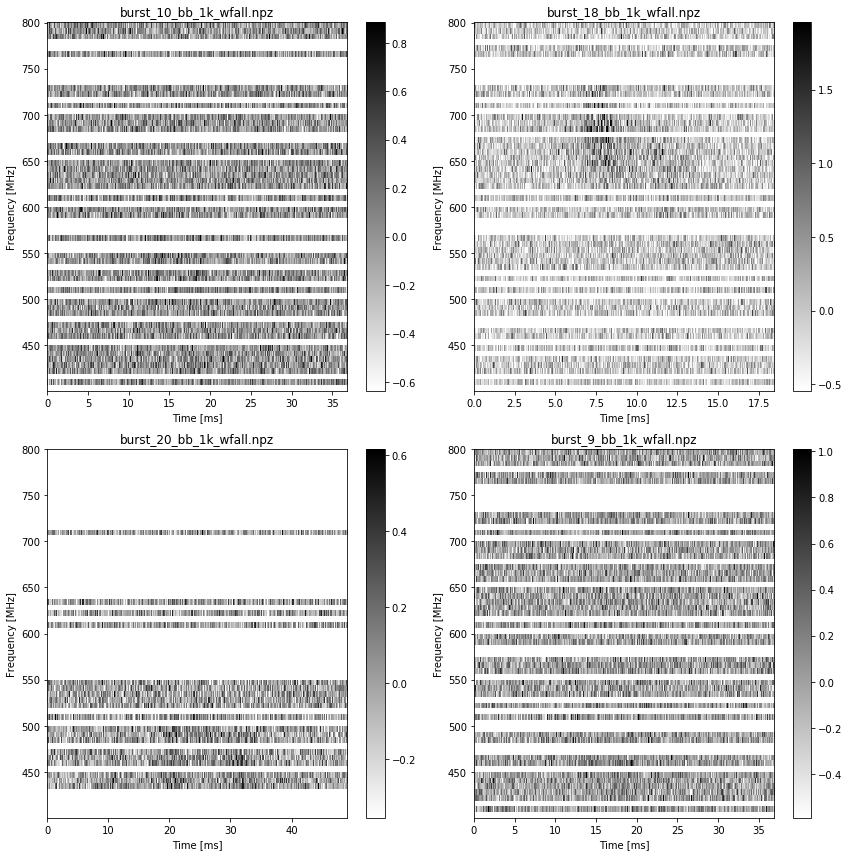

In [2]:
burstfiles = [s for s in os.listdir(folder) if 'bb' in s]

plt.figure(figsize=(12,12))
cmap = plt.get_cmap('gray_r')
cmap.set_bad(color = 'w', alpha = 1.) # potentially hides important errors in the data!

for fname in burstfiles:
    data = np.load("{}/{}".format(folder, fname))
    wfall = data["wfall"]
    wfall_z = np.nan_to_num(wfall)
    
    dt_s = data["dt_s"]
    center_freq_mhz = data["center_freq_mhz"]
    df_mhz = center_freq_mhz[1] - center_freq_mhz[0]
    
    plt.subplot(2,2,burstfiles.index(fname)+1)
 
    bb_downsample = 16
    plt.title(fname)
    plt.imshow(wfall[::16,:], origin="lower", aspect="auto", interpolation="nearest", cmap=cmap,
               extent=(0, 1000*dt_s*wfall.shape[1], center_freq_mhz[0]-df_mhz/2., center_freq_mhz[-1]+df_mhz/2.))
    plt.clim(np.min(wfall_z)*0.5, np.max(wfall_z)*0.5)
    plt.colorbar()
    plt.xlabel("Time [ms]")
    plt.ylabel("Frequency [MHz]")
    print(wfall[::16,:].shape)

plt.tight_layout()